# 寻找捐献者

In [122]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from time import time

from scipy.stats import skew # 数据偏斜度的计算
from sklearn.preprocessing import MinMaxScaler # 将数据缩放到0-1之间
from sklearn.cross_validation import train_test_split

from sklearn.metrics import fbeta_score, accuracy_score

from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression

from sklearn.grid_search import GridSearchCV
from sklearn.cross_validation import ShuffleSplit # 由于数据量比较小
from sklearn.metrics import make_scorer

%matplotlib inline

In [52]:
data = pd.read_csv('census.csv')
data.head()

,age,workclass,education_level,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,income
0,39,State-gov,Bachelors,13.0,Never-married,Adm-clerical,Not-in-family,White,Male,2174.0,0.0,40.0,United-States,<=50K
1,50,Self-emp-not-inc,Bachelors,13.0,Married-civ-spouse,Exec-managerial,Husband,White,Male,0.0,0.0,13.0,United-States,<=50K
2,38,Private,HS-grad,9.0,Divorced,Handlers-cleaners,Not-in-family,White,Male,0.0,0.0,40.0,United-States,<=50K
3,53,Private,11th,7.0,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0.0,0.0,40.0,United-States,<=50K
4,28,Private,Bachelors,13.0,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0.0,0.0,40.0,Cuba,<=50K


In [53]:
data.describe()

,age,education-num,capital-gain,capital-loss,hours-per-week
count,45222.000000,45222.000000,45222.000000,45222.000000,45222.000000
mean,38.547941,10.118460,1101.430344,88.595418,40.938017
std,13.217870,2.552881,7506.430084,404.956092,12.007508
min,17.000000,1.000000,0.000000,0.000000,1.000000
25%,28.000000,9.000000,0.000000,0.000000,40.000000
50%,37.000000,10.000000,0.000000,0.000000,40.000000
75%,47.000000,13.000000,0.000000,0.000000,45.000000
max,90.000000,16.000000,99999.000000,4356.000000,99.000000


In [54]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45222 entries, 0 to 45221
Data columns (total 14 columns):
age                45222 non-null int64
workclass          45222 non-null object
education_level    45222 non-null object
education-num      45222 non-null float64
marital-status     45222 non-null object
occupation         45222 non-null object
relationship       45222 non-null object
race               45222 non-null object
sex                45222 non-null object
capital-gain       45222 non-null float64
capital-loss       45222 non-null float64
hours-per-week     45222 non-null float64
native-country     45222 non-null object
income             45222 non-null object
dtypes: float64(4), int64(1), object(9)
memory usage: 4.8+ MB


In [55]:
# 查看收入大于50K的人数和比例
print np.sum(data['income']=='>50K')
print np.sum(data['income']=='<=50K')
print float(np.sum(data['income']=='>50K')) / data.shape[0]

11208
34014
0.247843969749


In [56]:
# 将数据切分成特征和对应的标签
income_raw = data['income']
features_raw = data.drop('income', axis = 1)

In [57]:
# 计算数值类型的数据的偏斜度
numeric_feats = data.dtypes[data.dtypes != 'object'].index
data[numeric_feats].apply(lambda x: skew(x.dropna()))
# 可以看到capital-gain 和 capital-loss 数据倾斜

age                0.532798
education-num     -0.310611
capital-gain      11.788611
capital-loss       4.516154
hours-per-week     0.340534
dtype: float64

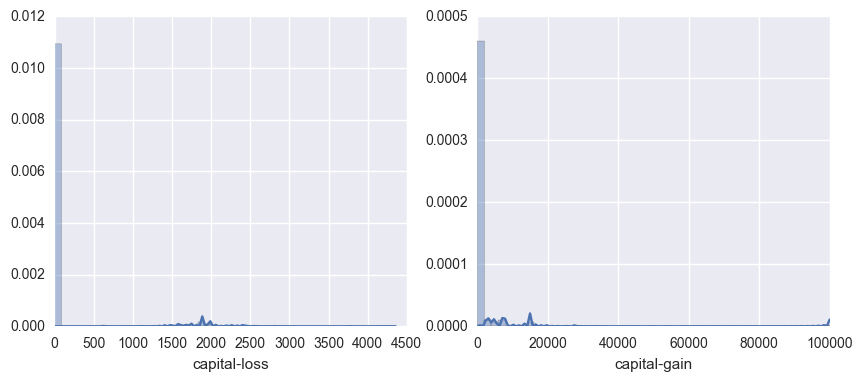

In [58]:
plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
sns.distplot(data['capital-loss'])
plt.subplot(1, 2, 2)
sns.distplot(data['capital-gain'])

In [59]:
# 对倾斜数据取对数,为了防止数据有0，所以用log1p
data['capital-gain'] = np.log1p(data['capital-gain'])
data['capital-loss'] = np.log1p(data['capital-loss'])

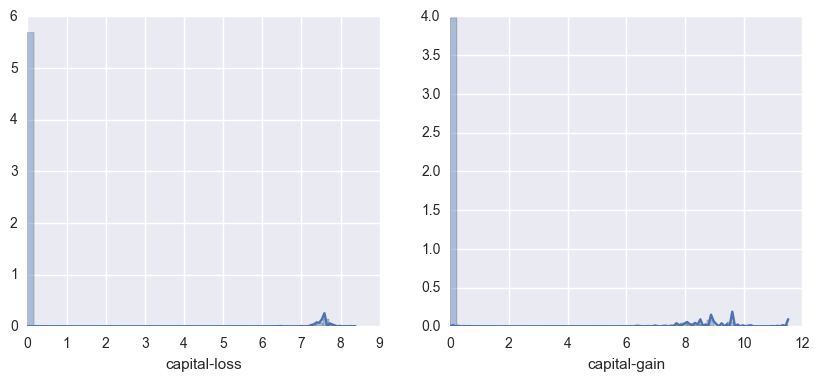

In [60]:
plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
sns.distplot(data['capital-loss'])
plt.subplot(1, 2, 2)
sns.distplot(data['capital-gain'])

In [62]:
# 数据归一化，规一化保证了每一个特征在使用监督学习器的时候能够被平等的对待
scaler = MinMaxScaler()
features_raw[numeric_feats] = scaler.fit_transform(data[numeric_feats])
features_raw.head()

,age,workclass,education_level,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country
0,0.301370,State-gov,Bachelors,0.800000,Never-married,Adm-clerical,Not-in-family,White,Male,0.667492,0.0,0.397959,United-States
1,0.452055,Self-emp-not-inc,Bachelors,0.800000,Married-civ-spouse,Exec-managerial,Husband,White,Male,0.000000,0.0,0.122449,United-States
2,0.287671,Private,HS-grad,0.533333,Divorced,Handlers-cleaners,Not-in-family,White,Male,0.000000,0.0,0.397959,United-States
3,0.493151,Private,11th,0.400000,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0.000000,0.0,0.397959,United-States
4,0.150685,Private,Bachelors,0.800000,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0.000000,0.0,0.397959,Cuba


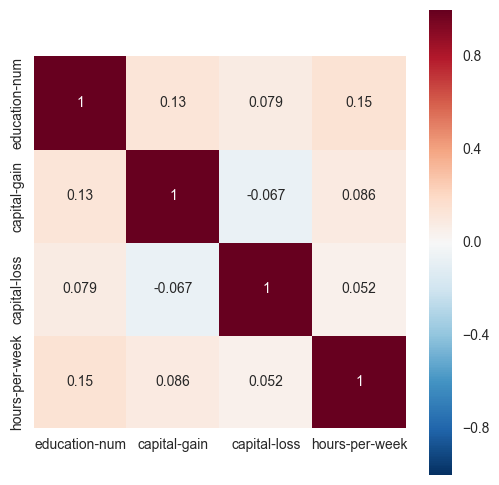

In [74]:
corr = data.select_dtypes(include=['float64', 'int']).iloc[:, 1:].corr()
plt.figure(figsize=(6, 6))
sns.heatmap(corr, square=1, annot=True)

In [69]:
# 对非数值特征进行特热编码
features = pd.get_dummies(features_raw)
income = [1 if d == '>50K' else 0 for d in income_raw]
income = np.array(income)
features.head()
# 变成了103个特征

,age,education-num,capital-gain,capital-loss,hours-per-week,workclass_ Federal-gov,workclass_ Local-gov,workclass_ Private,workclass_ Self-emp-inc,workclass_ Self-emp-not-inc,...,native-country_ Portugal,native-country_ Puerto-Rico,native-country_ Scotland,native-country_ South,native-country_ Taiwan,native-country_ Thailand,native-country_ Trinadad&Tobago,native-country_ United-States,native-country_ Vietnam,native-country_ Yugoslavia
0,0.301370,0.800000,0.667492,0.0,0.397959,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
1,0.452055,0.800000,0.000000,0.0,0.122449,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
2,0.287671,0.533333,0.000000,0.0,0.397959,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
3,0.493151,0.400000,0.000000,0.0,0.397959,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
4,0.150685,0.800000,0.000000,0.0,0.397959,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [70]:
# 切分数据
X_train, X_test, y_train, y_test = train_test_split(features, income, test_size = 0.2, random_state = 0)
print X_train.shape
print X_test.shape
print y_train.shape
print y_test.shape

(36177, 103)
(9045, 103)
(36177,)
(9045,)


### 数据预处理结束

----
## 评价模型性能
在这一部分中，我们将尝试四种不同的算法，并确定哪一个能够最好地建模数据。这里面的三个将是你选择的监督学习器，而第四种算法被称为一个*朴素的预测器*。


### 评价方法和朴素的预测器
*CharityML*通过他们的研究人员知道被调查者的年收入大于\$50,000最有可能向他们捐款。因为这个原因*CharityML*对于准确预测谁能够获得\$50,000以上收入尤其有兴趣。这样看起来使用**准确率**作为评价模型的标准是合适的。另外，把*没有*收入大于\$50,000的人识别成年收入大于\$50,000对于*CharityML*来说是有害的，因为他想要找到的是有意愿捐款的用户。这样，我们期望的模型具有准确预测那些能够年收入大于\$50,000的能力比模型去**召回**这些被调查者*更重要*。我们能够使用**F-beta score**作为评价指标，这样能够同时考虑准确率和召回率：

$$ F_{\beta} = (1 + \beta^2) \cdot \frac{precision \cdot recall}{\left( \beta^2 \cdot precision \right) + recall} $$


尤其是，当$\beta = 0.5$的时候更多的强调准确率，这叫做**F$_{0.5}$ score** （或者为了简单叫做F-score）。

通过查看不同类别的数据分布（那些最多赚\$50,000和那些能够赚更多的），我们能发现：很明显的是很多的被调查者年收入没有超过\$50,000。这点会显著地影响**准确率**，因为我们可以简单地预测说*“这个人的收入没有超过\$50,000”*，这样我们甚至不用看数据就能做到我们的预测在一般情况下是正确的！做这样一个预测被称作是**朴素的**，因为我们没有任何信息去证实这种说法。通常考虑对你的数据使用一个*朴素的预测器*是十分重要的，这样能够帮助我们建立一个模型的表现是否好的基准。那有人说，使用这样一个预测是没有意义的：如果我们预测所有人的收入都低于\$50,000，那么*CharityML*就不会有人捐款了。

### 监督学习模型
**下面的监督学习模型是现在在** [`scikit-learn`](http://scikit-learn.org/stable/supervised_learning.html) **中你能够选择的模型**
- 高斯朴素贝叶斯 (GaussianNB)
- 决策树
- 集成方法 (Bagging, AdaBoost, Random Forest, Gradient Boosting)
- K近邻 (KNeighbors)
- 随机梯度下降分类器 (SGDC)
- 支撑向量机 (SVM)
- Logistic回归


### 创建一个训练和预测的流水线
为了正确评估你选择的每一个模型的性能，创建一个能够帮助你快速有效地使用不同大小的训练集并在测试集上做预测的训练和测试的流水线是十分重要的。
你在这里实现的功能将会在接下来的部分中被用到。

 - 从[`sklearn.metrics`](http://scikit-learn.org/stable/modules/classes.html#sklearn-metrics-metrics)中导入`fbeta_score`和`accuracy_score`。
 - 用样例训练集拟合学习器，并记录训练时间。
 - 用学习器来对训练集进行预测并记录预测时间。
 - 在最前面的500个*训练数据*上做预测。
 - 计算训练数据和测试数据的准确率。
 - 计算训练数据和测试数据的F-score。


In [119]:
def train_predict(learner, sample_size, X_train, y_train, X_test, y_test):
    results = {}
    start = time()
    learner = learner.fit(X_train.head(sample_size), y_train[0:sample_size])
    end = time()
#     results['train_time'] = end - start
    
    start = time()
    prediction_test = learner.predict(X_test)
    prediction_train = learner.predict(X_train.head(300))
    end = time
#     results['pred_time'] = end - start
    
    results['acc_train'] = accuracy_score(y_train[0:300], prediction_train)
    results['acc_test'] = accuracy_score(y_test, prediction_test)
    
    results['f_train'] = fbeta_score(y_train[0:300], prediction_train, beta=0.5)
    results['f_test'] = fbeta_score(y_test, prediction_test, beta=0.5)
    
    print "{} trained on {} samples.".format(learner.__class__.__name__, sample_size)
    
    return results

In [120]:
# TODO：初始化三个模型，使用默认参数
clf_A = DecisionTreeClassifier()
clf_B = LogisticRegression()
clf_C = SVC()

# TODO：计算1%， 10%， 100%的训练数据分别对应多少点
samples_1 = int(0.01 * np.size(X_train, axis=0))
samples_10 = int(0.1 * np.size(X_train, axis=0))
samples_100 = np.size(X_train, axis=0)

results = {}
for clf in [clf_A, clf_B, clf_C]:
    clf_name = clf.__class__.__name__
    results[clf_name] = {}
    for i, samples in enumerate([samples_1, samples_10, samples_100]):
        results[clf_name][i] = train_predict(clf, samples, X_train, y_train, X_test, y_test)
        
print results

DecisionTreeClassifier trained on 361 samples.
DecisionTreeClassifier trained on 3617 samples.
DecisionTreeClassifier trained on 36177 samples.
LogisticRegression trained on 361 samples.
LogisticRegression trained on 3617 samples.
LogisticRegression trained on 36177 samples.
SVC trained on 361 samples.
SVC trained on 3617 samples.
SVC trained on 36177 samples.
{'LogisticRegression': {0: {'acc_train': 0.85999999999999999, 'f_train': 0.73863636363636354, 'acc_test': 0.81868435599778888, 'f_test': 0.62886019090398648}, 1: {'acc_train': 0.84666666666666668, 'f_train': 0.703125, 'acc_test': 0.8385848535102266, 'f_test': 0.67750677506775059}, 2: {'acc_train': 0.84666666666666668, 'f_train': 0.69852941176470584, 'acc_test': 0.841901603095633, 'f_test': 0.68316522824165538}}, 'SVC': {0: {'acc_train': 0.76000000000000001, 'f_train': 0.0, 'acc_test': 0.75621890547263682, 'f_test': 0.0}, 1: {'acc_train': 0.83333333333333337, 'f_train': 0.67129629629629628, 'acc_test': 0.83261470425649531, 'f_test

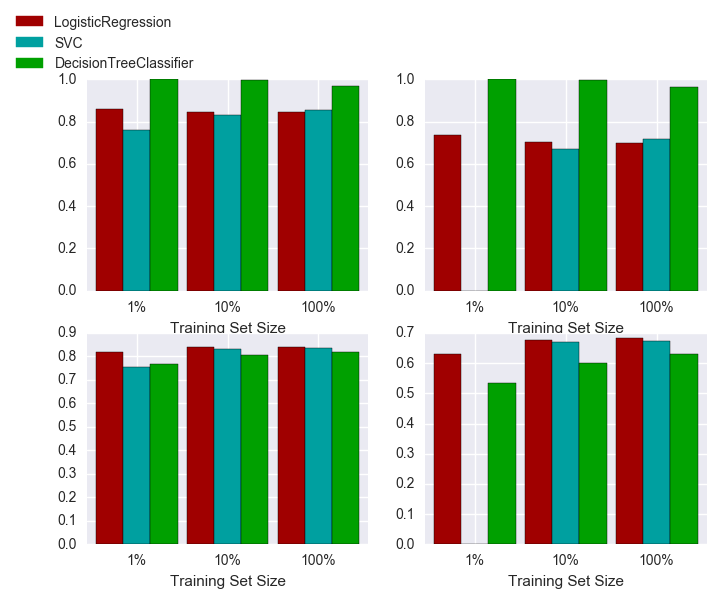

In [121]:
import matplotlib.patches as mpatches
fig, ax = plt.subplots(2, 2, figsize = (8, 6))
bar_width = 0.3
colors = ['#A00000','#00A0A0','#00A000']

for k, learner in enumerate(results.keys()):
    for j, metric in enumerate(['acc_train', 'f_train', 'acc_test', 'f_test']):
        for i in np.arange(3):
            ax[j/2, j%2].bar(i+k*bar_width, results[learner][i][metric], width = bar_width, color = colors[k])
            ax[j/2, j%2].set_xticks([0.45, 1.45, 2.45])
            ax[j/2, j%2].set_xticklabels(["1%", "10%", "100%"])
            ax[j/2, j%2].set_xlabel("Training Set Size")
            ax[j/2, j%2].set_xlim((-0.1, 3.0))
            
patches = []
for i, learner in enumerate(results.keys()):
    patches.append(mpatches.Patch(color = colors[i], label = learner))
    plt.legend(handles = patches, bbox_to_anchor = (-.80, 2.53), borderaxespad = 0.)

# print patches
plt.show()

选择决策树模型，使用网格搜索确定最优参数

In [123]:
def performance_metrics_beta(y_predict, y_true):
    score = fbeta_score(y_predict, y_true, beta=0.5)
    return score

cv_sets = ShuffleSplit(X_train.shape[0], n_iter = 10, test_size = 0.20, random_state = 0)

# TODO：初始化分类器
clf = DecisionTreeClassifier(random_state=0)

# TODO：创建你希望调节的参数列表
parameters = {'max_depth': [2,4,6,8,10]}

# TODO：创建一个fbeta_score打分对象
scorer = make_scorer(performance_metrics_beta)

# TODO：在分类器上使用网格搜索，使用'scorer'作为评价函数
grid_obj = GridSearchCV(clf, parameters, scorer, cv=cv_sets)

# TODO：用训练数据拟合网格搜索对象并找到最佳参数
grid_obj = grid_obj.fit(X_train, y_train)

# 得到estimator
best_clf = grid_obj.best_estimator_
print best_clf

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=8,
            max_features=None, max_leaf_nodes=None, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            presort=False, random_state=0, splitter='best')


In [124]:
# 使用没有调优的模型做预测
predictions = (clf.fit(X_train, y_train)).predict(X_test)
best_predictions = best_clf.predict(X_test)

# 汇报调参前和调参后的分数
print "Unoptimized model\n------"
print "Accuracy score on testing data: {:.4f}".format(accuracy_score(y_test, predictions))
print "F-score on testing data: {:.4f}".format(fbeta_score(y_test, predictions, beta = 0.5))
print "\nOptimized Model\n------"
print "Final accuracy score on the testing data: {:.4f}".format(accuracy_score(y_test, best_predictions))
print "Final F-score on the testing data: {:.4f}".format(fbeta_score(y_test, best_predictions, beta = 0.5))
print best_clf.get_params()['max_depth']

Unoptimized model
------
Accuracy score on testing data: 0.8186
F-score on testing data: 0.6279

Optimized Model
------
Final accuracy score on the testing data: 0.8524
Final F-score on the testing data: 0.7222
8


In [136]:
model = DecisionTreeClassifier(max_depth=8).fit(X_train, y_train)

# TODO： 提取特征重要性
importances = model.feature_importances_
indices = np.argsort(importances)[::-1]
print importances[indices[0:10]]

[ 0.41832402  0.2262469   0.19974587  0.07030493  0.04320134  0.02442687
  0.00409937  0.00347183  0.00344219  0.00128075]
